<a href="https://colab.research.google.com/github/Rohitmadgundi/Main-project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd


In [47]:
dataset = pd.read_csv('/content/sample_data/data/dataset.csv',delimiter=",")
severity = pd.read_csv('/content/sample_data/data/Symptom-severity.csv',delimiter=",",)
symptoms = severity["Symptom"]
training = pd.DataFrame()
temp = dataset.drop(columns=["Disease"])
temp = pd.DataFrame(temp[:].values)
for (i, values) in temp.iterrows():
   newRow = pd.DataFrame([dict.fromkeys(values.dropna().unique(),"1")])
   training = training.append(newRow)
training = training.reset_index(drop=True)
training["Prognosis"] = dataset["Disease"]
training.to_csv('/content/sample_data/data/training.csv')


In [49]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training = pd.read_csv('/content/sample_data/data/training.csv',delimiter=",",index_col=0).fillna(0)

cols= training.columns
cols= cols[:-1]
x = training[cols]
y = training['Prognosis']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(y_train)
print(y_test)


4308             Chronic cholestasis
2269                     Hepatitis C
3022                    Heart attack
442              Chronic cholestasis
4072    Paralysis (brain hemorrhage)
                    ...             
4426                       Psoriasis
466              Peptic ulcer diseae
3092                          Dengue
3772                Fungal infection
860                    Drug Reaction
Name: Prognosis, Length: 3296, dtype: object
373                    Acne
4916                   Acne
1550        Hyperthyroidism
3081                   AIDS
3857    Chronic cholestasis
               ...         
1257                   GERD
3346           Tuberculosis
3384            Hepatitis D
3290          Hypertension 
1178              Arthritis
Name: Prognosis, Length: 1624, dtype: object


In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

classifier  = DecisionTreeClassifier()

classifierModel = classifier.fit(x_train.values,y_train.values)
scores = cross_val_score(classifierModel, x_test, y_test, cv=3)
print("%0.2f accuracy for decision tree classifier with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.97 accuracy for decision tree classifier with a standard deviation of 0.00


[Text(0.6666666666666666, 0.875, ' runny_nose <= 0.5\ngini = 0.976\nsamples = 3296\nvalue = [83, 78, 78, 80, 84, 78, 72, 83, 82, 89, 86, 74\n85, 70, 82, 87, 77, 77, 78, 73, 80, 82, 70, 83\n78, 76, 82, 84, 83, 85, 81, 90, 82, 89, 74, 87\n80, 79, 79, 80, 76]\nclass = Osteoarthristis'),
 Text(0.5, 0.625, ' internal_itching <= 0.5\ngini = 0.975\nsamples = 3210\nvalue = [83, 78, 78, 80, 84, 78, 72, 83, 82, 89, 0, 74\n85, 70, 82, 87, 77, 77, 78, 73, 80, 82, 70, 83\n78, 76, 82, 84, 83, 85, 81, 90, 82, 89, 74, 87\n80, 79, 79, 80, 76]\nclass = Osteoarthristis'),
 Text(0.3333333333333333, 0.375, ' hip_joint_pain <= 0.5\ngini = 0.974\nsamples = 3124\nvalue = [83, 78, 78, 80, 84, 78, 72, 83, 82, 89, 0, 74\n85, 70, 82, 87, 77, 77, 78, 73, 80, 82, 70, 83\n78, 76, 82, 84, 83, 85, 81, 90, 82, 3, 74, 87\n80, 79, 79, 80, 76]\nclass = Osteoarthristis'),
 Text(0.16666666666666666, 0.125, '\n  (...)  \n'),
 Text(0.5, 0.125, '\n  (...)  \n'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 86\nvalue

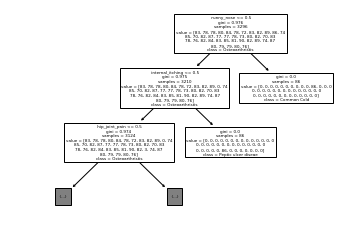

In [51]:
from sklearn import tree
features = x_train.columns
tree.plot_tree(classifierModel,feature_names=features, class_names=sorted(classifierModel.classes_),max_depth=2)


In [52]:
from sklearn.svm import SVC

svcModel=SVC()
svcModel.fit(x_train.values,y_train.values)
print("%0.2f accuracy for svm" % (svcModel.score(x_test.values,y_test.values)))


1.00 accuracy for svm


In [53]:
severities = pd.read_csv('/content/sample_data/data/Symptom-severity.csv',delimiter=",")
descriptions = pd.read_csv('/content/sample_data/data/symptom_Description.csv',delimiter=",")
precautions = pd.read_csv('/content/sample_data/data/symptom_precaution.csv',delimiter=",")
diseasesData = pd.read_csv('/content/sample_data/data/dataset.csv',delimiter=",")
precautions.set_index("Disease",inplace=True)
descriptions.set_index("Disease",inplace=True)

modelTree = classifierModel.tree_

groupedData = training.groupby(training['Prognosis']).max()

In [54]:
from sklearn.tree import _tree
le = preprocessing.LabelEncoder()
le.fit(y_train)
#y = le.transform(y)

def walkTree(node, userInput):
    names = training.columns[:-1]
    featureNames = [
        names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in modelTree.feature
     ]
    
    if modelTree.feature[node] != _tree.TREE_UNDEFINED:
            name = featureNames[node]
            threshold = modelTree.threshold[node]
            if name.strip() == userInput.strip():
                val = 1
            else:
                val = 0
            if  val <= threshold:
                return walkTree(modelTree.children_left[node],userInput)
            else:
                return walkTree(modelTree.children_right[node], userInput)
    else:
        #print(modelTree.value[node])
        node = modelTree.value[node][0].nonzero()
        disease = le.inverse_transform(node[0])
        possibleDisease = disease[0]
        indices  = groupedData.loc[disease].values[0].nonzero()
        columnList = groupedData.columns.values[0]
        symptomSuggestions = [groupedData.columns.values[i] for i in indices][0]
        return (symptomSuggestions , possibleDisease) 


In [55]:
(symptomSuggestions, possibleDisease) = walkTree(0,"itching")
print(symptomSuggestions, possibleDisease)


['itching' ' skin_rash' ' stomach_pain' ' burning_micturition'
 ' spotting_ urination'] Drug Reaction


In [56]:
import numpy as np
def makePrediction(experiencedSymptoms):
    x = training.iloc[:, :-1]
    symptomsDict = {symptom.strip(): index for index, symptom in enumerate(x)}
    inputVector = np.zeros(len(symptomsDict))
    for s in experiencedSymptoms:
      inputVector[[symptomsDict[s]]] = 1
    #print(classifierModel.predict([inputVector]))
    return classifierModel.predict([inputVector])[0]


In [57]:
makePrediction(["weight_loss"])


'Jaundice'

In [58]:
import re
def getRelatedSymptoms(userInput):
    result=[]
    symptoms = severities['Symptom']
    userInput=userInput.replace(' ','_')
    pattern = f"{userInput}"
    regexp = re.compile(pattern)
    predictionList=[item.replace('_',' ') for item in symptoms if regexp.search(item)]
    if(len(predictionList)>0):
        return (True,predictionList)
    else:
        return (False, [])


In [59]:
getRelatedSymptoms("e")


(True,
 ['nodal skin eruptions',
  'continuous sneezing',
  'shivering',
  'ulcers on tongue',
  'muscle wasting',
  'fatigue',
  'weight gain',
  'anxiety',
  'cold hands and feets',
  'weight loss',
  'restlessness',
  'lethargy',
  'patches in throat',
  'irregular sugar level',
  'high fever',
  'sunken eyes',
  'breathlessness',
  'sweating',
  'dehydration',
  'indigestion',
  'headache',
  'yellowish skin',
  'dark urine',
  'nausea',
  'loss of appetite',
  'pain behind the eyes',
  'diarrhoea',
  'mild fever',
  'yellow urine',
  'yellowing of eyes',
  'acute liver failure',
  'fluid overload',
  'swelling of stomach',
  'swelled lymph nodes',
  'malaise',
  'blurred and distorted vision',
  'phlegm',
  'redness of eyes',
  'sinus pressure',
  'runny nose',
  'congestion',
  'chest pain',
  'weakness in limbs',
  'fast heart rate',
  'pain during bowel movements',
  'pain in anal region',
  'neck pain',
  'dizziness',
  'obesity',
  'swollen legs',
  'swollen blood vessels',
 

In [60]:
def getRelatedSymptomsFromUser():
    print("\nEnter the symptom you are experiencing \t\t",end="->") 
    userInput = input("") 
    return getRelatedSymptoms(userInput)


In [61]:
def getSymptomsChoiceFromUser(relatedSymptoms):
    print("searches related to input: ") 
    for num, it in enumerate(relatedSymptoms): 
        print(num,")",it)
    i=0
    if num!=0: 
        print(f"Select the one you meant (0 - {num}): ", end="") 
        try:
            i = int(input("")) 
        except:
            pass
    else: 
        i=0 
    return relatedSymptoms[i]


In [62]:
def getAdditionalSymptomsFromUser(symptomSuggestions):
    result = []
    print("Are you experiencing any ")
    for s in symptomSuggestions:
        inp=""
        print(s,"? : ",end='')
        while True:
            inp=input("")
            if(inp=="yes" or inp=="no"):
                break
            else:
                print("provide proper answers i.e. (yes/no) : ",end="")
            if(inp=="yes"):
                result.append(s)
    return result


In [63]:
def printDiseaseRecommendation(disease):
    print("You may have ", disease)
    print(descriptions.loc[disease].values[0])
    print("Take the following precautions: ")
    for p in precautions.loc[disease].values:
        print("- " + str(p))


In [64]:
printDiseaseRecommendation("hepatitis A")


You may have  hepatitis A
Hepatitis A is a highly contagious liver infection caused by the hepatitis A virus. The virus is one of several types of hepatitis viruses that cause inflammation and affect your liver's ability to function.
Take the following precautions: 
- Consult nearest hospital
- wash hands through
- avoid fatty spicy food
- medication


In [66]:
print("-----------------------------------HealthCare ChatBot-----------------------------------")
print("\nWhat's your name? \t\t\t\t",end="->")
userName = input("Hello: ")
print("Hello,",userName,"! Nice to see you!")

while True:
    currentSymptom = "" 
    (result, relatedSymptoms) = getRelatedSymptomsFromUser()
    if result == True: 
        currentSymptom = getSymptomsChoiceFromUser(relatedSymptoms)
        (symptomSuggestions, possibleDisease) = walkTree(0, currentSymptom.replace(" ","_"))
        #print(symptomSuggestions,possibleDisease )
        additionalSymptoms = getAdditionalSymptomsFromUser(symptomSuggestions)
        #print(additionalSymptoms)
        otherPossibleDisease = makePrediction(additionalSymptoms)
        printDiseaseRecommendation(possibleDisease)
        if not possibleDisease == otherPossibleDisease:
            print("You may also have: \n")
            printDiseaseRecommendation(otherPossibleDisease)
            print("\n")
    print("Bye!")
    break


-----------------------------------HealthCare ChatBot-----------------------------------

What's your name? 				->Hello: mahesh
Hello, mahesh ! Nice to see you!

Enter the symptom you are experiencing 		->itching
searches related to input: 
0 ) itching
1 ) internal itching
Select the one you meant (0 - 1): 1
Are you experiencing any 
 vomiting ? : no
 loss_of_appetite ? : no
 abdominal_pain ? : no
 passage_of_gases ? : yes
 internal_itching ? : yes
 indigestion ? : no
You may have  Peptic ulcer diseae
Peptic ulcer disease (PUD) is a break in the inner lining of the stomach, the first part of the small intestine, or sometimes the lower esophagus. An ulcer in the stomach is called a gastric ulcer, while one in the first part of the intestines is a duodenal ulcer.
Take the following precautions: 
- avoid fatty spicy food
- consume probiotic food
- eliminate milk
- limit alcohol
You may also have: 

You may have  Alcoholic hepatitis
Alcoholic hepatitis is a diseased, inflammatory condition